# Set-up

In [163]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import xarray as xr
import seqpro as sp
import seqdata as sd
from eugene import models
from eugene.models import zoo
import seqexplainer as se
from eugene import plot as pl
import seaborn as sns
import matplotlib.pyplot as plt
from seqexplainer.attributions._plot import plot_attribution_logo, plot_attribution_logo_heatmap
from tqdm.auto import tqdm  # progress bar to use for evolution

sys.path.append("/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/bin")
from plot import scatter

In [2]:
# Model log directory
date = "2023_12_16"
rbp = "RNCMPT00100"
normalization = "log_norm"
log_dir = f"/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/models/{date}/ResidualBind/{normalization}/{rbp}"

# Check if log directory exists
if not os.path.isdir(log_dir):
    print(f"Log directory {log_dir} does not exist")

# Check if model exists
best_path = os.path.join(log_dir, "best_model.ckpt")
if not os.path.isfile(best_path):
    print(f"Model {best_path} does not exist")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Load test dataset

In [204]:
# Load the dataset
sdata = sd.open_zarr("/cellar/users/aklie/data/ml4gland/pubs/koo21_gia/log_norm/rnacompete2013_test.zarr")
sdata.load()

<xarray.Dataset>
Dimensions:    (_sequence: 121031, _length: 41, _ohe: 4, _target: 244)
Dimensions without coordinates: _sequence, _length, _ohe, _target
Data variables:
    inputs     (_sequence, _length, _ohe) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rbp_id     (_target) <U11 'RNCMPT00100' 'RNCMPT00101' ... 'RNCMPT00009'
    rbp_index  (_target) int64 0 1 2 3 4 5 6 7 ... 237 238 239 240 241 242 243
    targets    (_sequence, _target) float32 0.795 -0.2654 -0.2193 ... 0.6552 nan

In [82]:
# Random select 1000 sequence indices
np.random.seed(1234)
idx = np.random.choice(sdata.dims["_sequence"], 1000, replace=False)

# Subset the dataset
sdata = sdata.isel(_sequence=idx)

In [205]:
# Get seqs to predict on
X_test_np = sdata["inputs"].values.transpose(0, 2, 1)

# Get target vector
target_ind = np.where(sdata["rbp_id"].values == rbp)[0]
targets = sdata["targets"][:, target_ind].values.squeeze()

# Load best model

In [84]:
# Instantiate an architecture
arch = zoo.ResidualBind(
    input_len=41,
    output_dim=1
)

In [85]:
module = models.SequenceModule.load_from_checkpoint(
    os.path.join(log_dir, "best_model.ckpt"),
    arch=arch,
)

[rank: 0] Global seed set to 1234


# Get predictions

In [86]:
module.to(device).eval();

In [87]:
preds = module.predict(X_test_np, batch_size=128).cpu().numpy().squeeze()

Predicting on batches:   0%|          | 0/7 [00:00<?, ?it/s]

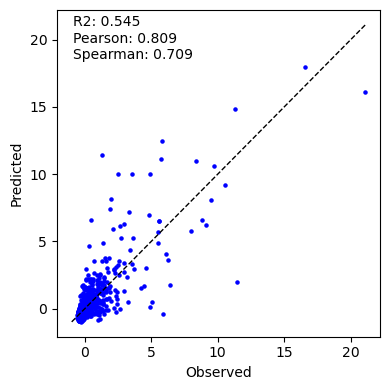

In [88]:
scatter(
    preds,
    targets,
    density=False,
    rasterized=True,
    s=5,
)

In [90]:
# Add predictions to dataset
sdata["preds"] = xr.DataArray(preds, dims=["_sequence"])

# In silico mutagenesis

In [127]:
# Make output directory if it doesn't exist
outdir = os.path.join(log_dir, "attribution")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [91]:
attrs = se.attribute(
    module, 
    X_test_np,
    method="NaiveISM", 
    hypothetical=True, 
    attribution_func=None
)

Computing attributions on batches of size 128:   0%|          | 0/8 [00:00<?, ?it/s]

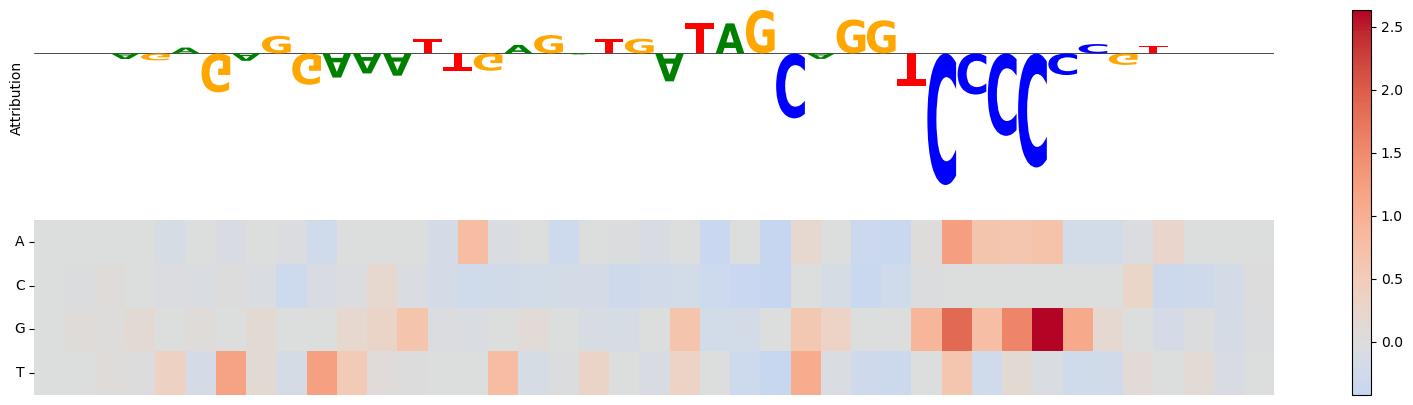

In [93]:
# Example visualization
plot_attribution_logo_heatmap(attrs[3], inputs=sdata["inputs"].values.transpose(0, 2, 1)[3], flip_sign=True, figsize=(20, 5))

In [95]:
# Add attributions
sdata["attributions"] = xr.DataArray(attrs, dims=["_sequence", "_ohe", "_length"])

In [128]:
# Save attributions as ism.npz
np.savez_compressed(os.path.join(outdir, "ism.npz"), attrs)

In [130]:
# Save ohe sequences as ohe.npz
np.savez_compressed(os.path.join(outdir, "ohe.npz"), X_test_np)

# Filter interpretation

In [206]:
# This is the seqexplainer function for getting the outputs from a layer
from seqexplainer import get_layer_outputs, get_activators_n_seqlets, get_pfms, plot_filter_logos, annotate_pfms
from motifdata import from_kernel, write_meme
from motifdata._transform import pfms_to_ppms

In [207]:
# Make output directory if it doesn't exist
outdir = os.path.join(log_dir, "filter_interpretation")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [208]:
# Get the first layer of the model
layer_name = "arch.conv1d_tower.layers.0"
X_test_torch = torch.tensor(X_test_np, dtype=torch.float32)

In [209]:
# This is the seqexplainer function for getting the outputs from a layer, see the API docs for more info
activations = get_layer_outputs(
    model=module,
    inputs=X_test_torch,
    layer_name=layer_name,
    batch_size=128,
    device="cuda",
    verbose=True
)

Computing layer outputs for layer arch.conv1d_tower.layers.0 on batches of size 128:   0%|          | 0/946 [0…

In [210]:
# This first one simply grabs the top n seqlets from the activations and sequences we pass in
mas = get_activators_n_seqlets(
    activations=activations,
    sequences=X_test_np,
    kernel_size=11,
    padding=0,
    num_seqlets=50,
    num_filters=None
)

Getting filter activators for 96 filters:   0%|          | 0/96 [00:00<?, ?it/s]

In [211]:
# Get position frequency matrices from these seqlets
pfms = get_pfms(
    filter_activators=mas,
    kernel_size=11
)

In [212]:
# Convert pfms to ppms and to a motif set
ppms = pfms_to_ppms(pfms.transpose(0, 2, 1), pseudocount=0)
motif_set = from_kernel(kernel=ppms, alphabet="ACGU", bg={"A": 0.25, "C": 0.25, "G": 0.25, "U": 0.25})

In [213]:
# Write the motif set to a meme file
write_meme(motif_set=motif_set, filename=os.path.join(outdir, "filters.meme"))

Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/models/2023_12_16/ResidualBind/log_norm/RNCMPT00100/filter_interpretation/filters.meme


In [223]:
match_df = annotate_pfms(
    filename=os.path.join(outdir, "filters.meme"),
    motifs_db="/cellar/users/aklie/data/shared/meme/motif_databases/RNA/Ray2013_rbp_All_Species.meme",
    output_dir=outdir,
    out_filename="tomtom_annotation.tsv",
)

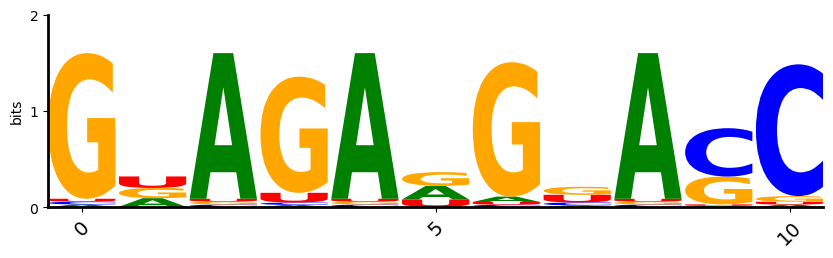

In [229]:
plot_filter_logos(mtxs=np.expand_dims(pfms[int(match_df.sort_values("q-value")["Query_ID"].iloc[0].split("_")[-1])], 0), vocab="RNA")    

# Sequence evolution

In [230]:
from seqexplainer import evolution
import logomaker as lm

In [231]:
# Make output directory if it doesn't exist
outdir = os.path.join(log_dir, "evolution")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [232]:
# Generate 10 One-hot encoded sequences
random_seqs = sp.ohe(sp.random_seqs(shape=(10, 41), alphabet=sp.RNA), alphabet=sp.RNA).transpose(0, 2, 1)

In [233]:
# 5 rounds of evolution
rounds = 5
evolved_seqs = []
deltas = np.zeros((len(random_seqs), rounds))
mutation_pos = []
for i, random_seq in tqdm(enumerate(random_seqs), total=random_seqs.shape[0], desc="Evolving sequences"):
    evolved_res = evolution(
        model=module,
        X=random_seq,
        rounds=rounds,
    )
    evolved_seqs.append(evolved_res[0])
    deltas[i, :] = deltas[i, :] + evolved_res[1]
    mutation_pos.append(evolved_res[2])
X_evolved = torch.tensor(np.array(evolved_seqs), dtype=torch.float32)
mutation_pos = np.array(mutation_pos)

Evolving sequences:   0%|          | 0/10 [00:00<?, ?it/s]

In [237]:
# Create a dataframe for scores
scores = {}
scores[0] = module.predict(random_seqs, batch_size=32, verbose=False).detach().cpu().numpy().squeeze()
for i in range(1, rounds+1):
    scores[i] = scores[i-1] + deltas[:, i-1]
score_df = pd.DataFrame(scores)
score_df.columns = ["round_{}".format(i) for i in range(rounds+1)]
score_df.to_csv(os.path.join(outdir, "evolution_scores.csv"), index=False)
score_df.head()

,round_0,round_1,round_2,round_3,round_4,round_5
0,-0.364389,-0.246076,-0.144373,0.167294,0.936573,2.820251
1,-0.007857,0.865968,4.039605,10.054814,13.608616,17.773031
2,-0.306558,1.229672,7.016309,13.542887,20.030855,24.950630
3,-0.026774,1.050231,2.041005,3.407338,5.064667,8.033596
4,7.003695,16.640461,19.504036,21.893171,24.427364,26.824247


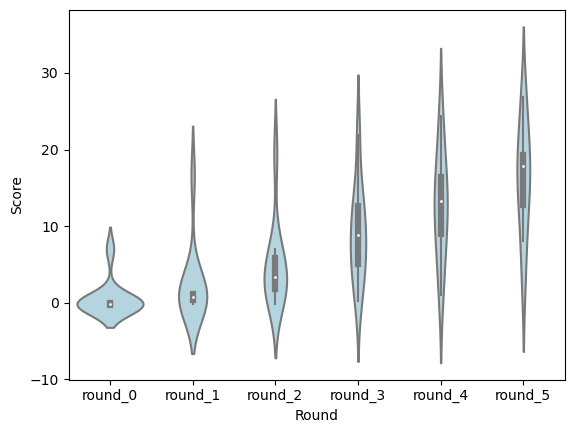

In [238]:
# Make a violinplot of the scores at each round
g = sns.violinplot(data=score_df, color="lightblue")
g.set_xlabel("Round")
g.set_ylabel("Score")
plt.savefig(os.path.join(outdir, "evolution_violinplot.png"), dpi=300, bbox_inches="tight")

In [239]:
# Get the attributions for the random and evolved sequences
random_attrs = se.attribute(
    model=module,
    inputs=random_seqs,
    method="NaiveISM",
    hypothetical=True, 
    attribution_func=None
)
evolved_attrs = se.attribute(
    model=module,
    inputs=X_evolved.numpy(),
    method="NaiveISM",
    hypothetical=True, 
    attribution_func=None
)

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

In [240]:
# Adjust the attributions to sum to 0
def negative_average(ism_attr, inputs):
    avgs = ism_attr.mean(1) * -1
    avgs = avgs.reshape(avgs.shape[0], -1, avgs.shape[-1])
    avgs = np.repeat(avgs, 4, axis=1)
    ism_attr = inputs * avgs
    return ism_attr

random_attrs = negative_average(random_attrs, random_seqs)
evolved_attrs = negative_average(evolved_attrs, X_evolved.numpy())

Plotting:   0%|          | 0/10 [00:00<?, ?it/s]

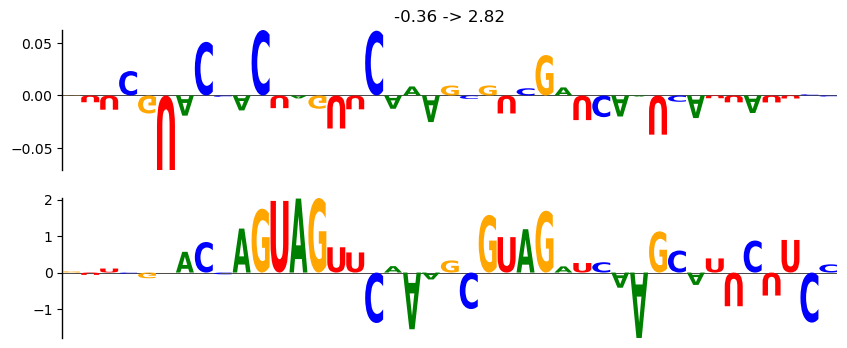

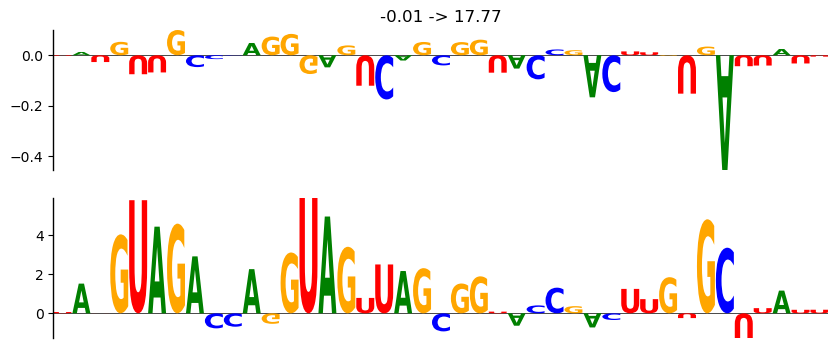

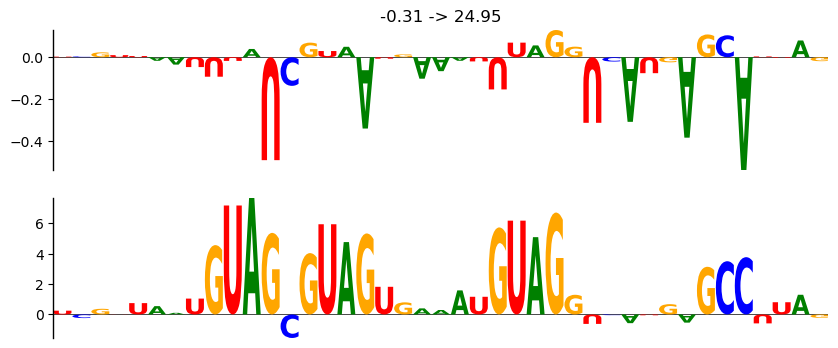

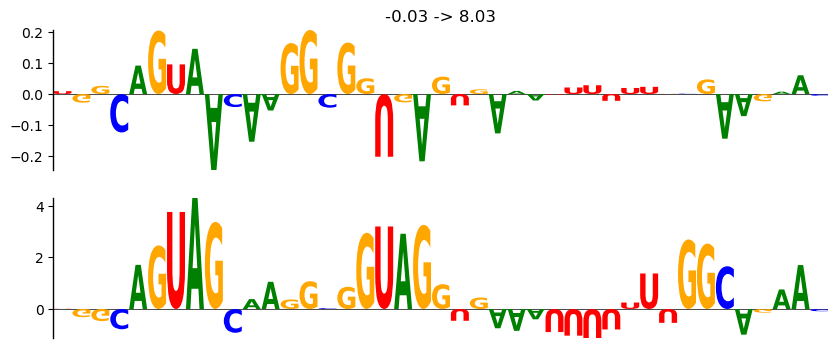

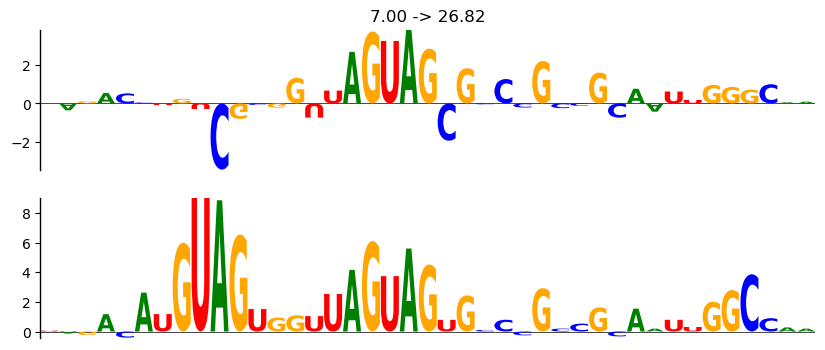

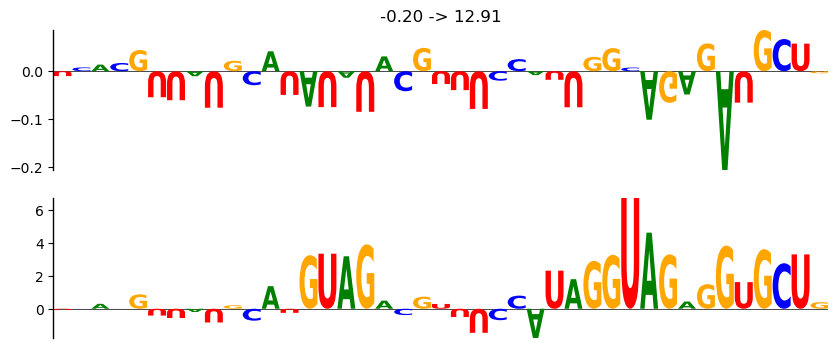

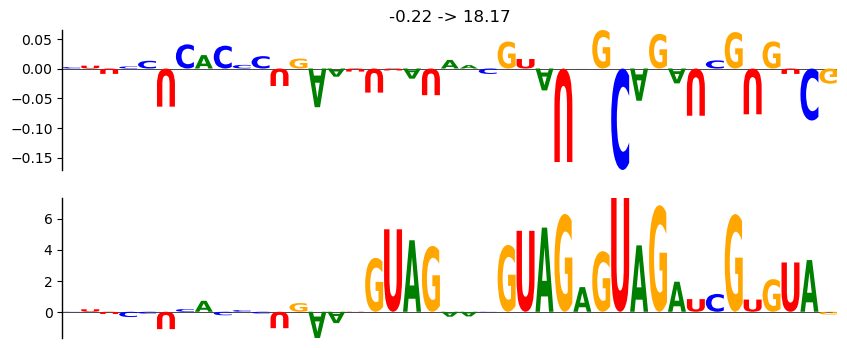

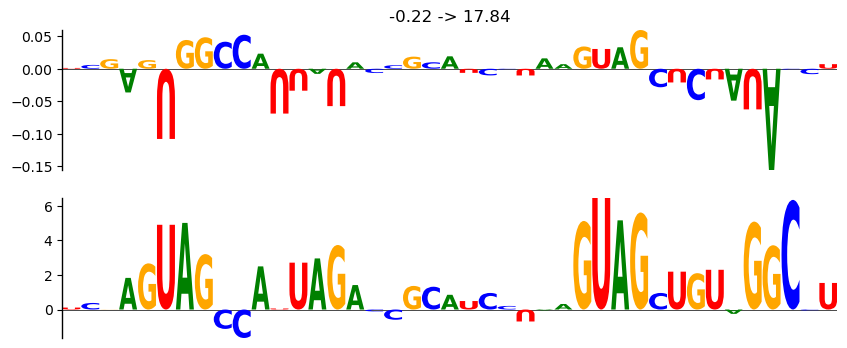

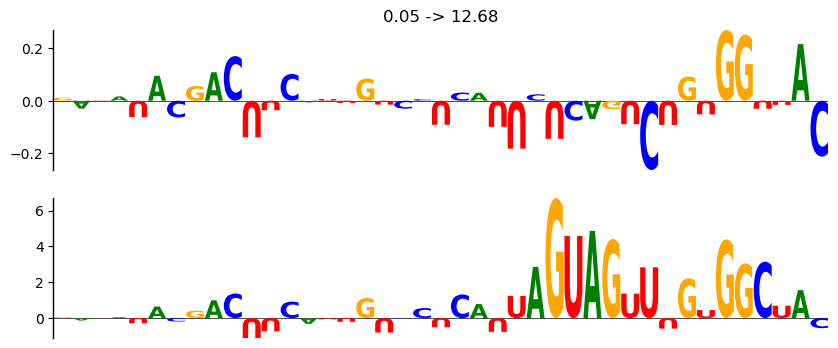

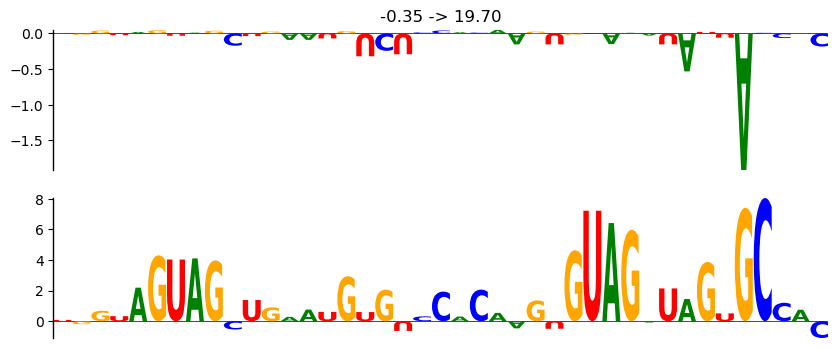

In [242]:
# Complicated plotting that we will eventually turn into a built in function
for i in tqdm(range(len(random_attrs)), desc="Plotting", total=len(random_attrs)):
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    random_viz_seq = pd.DataFrame(random_attrs[i].T, columns=["A", "C", "G", "U"])
    random_viz_seq.index.name = "pos"
    random_logo = lm.Logo(random_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[0])
    random_logo.style_spines(visible=False)
    random_logo.style_spines(spines=['left'], visible=True)
    random_logo.ax.set_xticks([])
    ax[0].set_title(f"{scores[0][i].item():.2f} -> {scores[5][i].item():.2f}")
    ax_bottom = ax[0].get_ylim()[0]
    evolved_viz_seq = pd.DataFrame(evolved_attrs[i].T, columns=["A", "C", "G", "U"])
    evolved_viz_seq.index.name = "pos"
    evolved_logo = lm.Logo(evolved_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[1])
    evolved_logo.style_spines(visible=False)
    evolved_logo.style_spines(spines=['left'], visible=True)
    evolved_logo.ax.set_xticks([])
    plt.savefig(os.path.join(outdir, f"evolution_seq{i}_attrs.png"), bbox_inches="tight")

# DONE!

---